In [1]:
from sklearn.datasets import make_classification
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
X, y = make_classification(n_samples=10000, 
                           n_features=15, 
                           n_classes=4, 
                           n_informative=4,
                           n_clusters_per_class=4, 
                           shuffle=True, 
                           random_state=10)

In [8]:
df = pd.DataFrame(X)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.012681,-1.338834,-0.866080,0.473458,-0.358800,-1.550780,0.025097,0.893646,0.137707,0.114673,0.805211,1.275425,-0.433597,-0.843272,-0.943528
1,-1.445707,-0.332821,0.211231,0.910813,-0.699548,-0.227023,-0.383575,0.380534,-1.393787,-0.044172,0.336022,-0.179394,2.162269,-0.851507,-1.577097
2,-1.280569,0.901854,-0.154279,-0.638947,2.809805,-0.492652,-0.821869,-1.288953,-1.723267,2.363540,-0.809070,-2.285855,-2.890212,1.328072,-0.665873
3,0.259420,-1.309103,1.916366,0.275198,0.233706,-1.738353,-0.086993,0.336356,-0.012801,-0.572615,0.552491,0.435610,-1.280618,-0.559114,0.688667
4,0.772607,0.995262,0.288318,-0.360519,0.307231,-1.536211,-1.202458,-0.229592,-0.940400,-0.248410,-0.001390,-1.605799,-0.805429,-0.079946,-0.688126


In [9]:
from collections import Counter

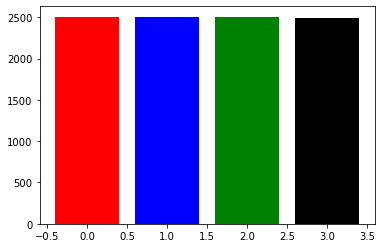

In [10]:
plt.bar(np.unique(y), Counter(y).values(), color = ['red', 'blue', 'green', 'black']);

In [11]:
from sklearn.cluster import KMeans

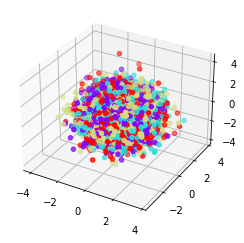

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0],X[:,1],X[:,2], c= y, cmap ='rainbow');

In [13]:
km = KMeans(n_clusters = 4, random_state = 10, max_iter = 1000)
km.fit(X[:,:3])
y_3d = km.predict(X[:,:3])

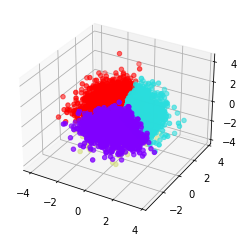

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0],X[:,1],X[:,2], c= y_3d, cmap ='rainbow');

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((2000, 15), (2000,), (8000, 15), (8000,))

In [32]:
km = KMeans(n_clusters = 4, random_state = 10, max_iter = 30)
km.fit(X)
y_preds_km = km.predict(X)

In [33]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_preds_km)

0.2011

### Spherical from Scratch.

In [2]:
def init_mean_cov(K,data_arr,label_arr):
    mean_ls = [] ## List containing mean values of the clusters
    cov_ls = []
    size_ls = []
    cluster_ls = [[] for k in range(K)] ## Create list of empty lists to store data belonging to a certain cluster
    
    for i in range(len(label_arr)):
        for k in range(K):
            if label_arr[i] == k:  ## if the label of the data at ith row is 'k'
                norm_data = np.ravel(data_arr[i,:])/np.linalg.norm(np.ravel(data_arr[i,:]))
                cluster_ls[k].append(norm_data) ## Fill the kth empty list with this data value                
    
    for k in range(K): 
        cluster_mat = np.matrix(cluster_ls[k])
        pointNum = cluster_mat.shape[0]
        cov_k = np.cov(cluster_mat.T)
        mean_k = np.mean(cluster_mat,axis=0)
        mean_k = np.ravel(mean_k)/np.linalg.norm(np.ravel(mean_k))
        mean_ls.append(mean_k)
        cov_ls.append(cov_k)
        size_ls.append(pointNum)
    return(mean_ls,cov_ls,size_ls)    

In [3]:
def similarity(vec1,vec2):
    
    vec1 = np.ravel(vec1)
    vec1 = vec1/np.linalg.norm(vec1)

    vec2 = np.ravel(vec2)
    vec2 = vec2/np.linalg.norm(vec2)
    
    sim = np.dot(vec1,vec2)
    
    return(sim)

In [4]:
def mean_from_label(K,prev_mean,prev_cov,prev_size,data_arr,label_arr):
    cluster_ls = [[] for k in range(K)]  ## Create list of empty lists to store data belonging to a certain cluster
    
    for i in range(data_arr.shape[0]):
        for k in range(K):
            if label_arr[i] == k: 
                norm_data = np.ravel(data_arr[i,:])/np.linalg.norm(np.ravel(data_arr[i,:]))
                cluster_ls[k].append(norm_data) ## Fill the kth empty list with this pixel value
                    
    for k in range(K):
        if len(cluster_ls[k]) !=0:  ## Only update the means of those clusters which has received at least one new point, else retain the old mean value
            cluster_mat = np.matrix(cluster_ls[k])
            pointNum = cluster_mat.shape[0]
            mean_k = np.mean(cluster_mat,axis=0)
            cov_k = np.cov(cluster_mat.T)
            mean_k = np.ravel(mean_k)/np.linalg.norm(np.ravel(mean_k))
            prev_mean[k] = mean_k
            prev_cov[k] = cov_k
            prev_size[k] = pointNum
    new_mean = prev_mean
    new_cov = prev_cov
    new_size = prev_size
    return(new_mean,new_cov,new_size)    

In [5]:
def SphericalKMeans(data_arr,label_arr,K,maxIter):
    mean_old,cov_old,size_old = init_mean_cov(K,data_arr,label_arr)
    for t in range(maxIter):
        new_label_arr = label_update(mean_old,data_arr,label_arr)
        mean_new,cov_new,size_new = mean_from_label(K,mean_old,cov_old,size_old,data_arr,new_label_arr)
        label_arr = new_label_arr ## Update the label array
        mean_old = mean_new ## Update the mean values
        cov_old = cov_new
        size_old = size_new
        if t == maxIter-1:
            print("Iteration {} is complete during training!!".format(t+1))
        if t % 10:
            print("Iteration {} is complete during training!!".format(t+1))
            
    return(mean_new,cov_new,size_new, label_arr)

In [6]:
def label_update(prev_mean,data_arr,label_arr):
    for i in range(data_arr.shape[0]):
        dist_ls = [] 
        for k in range(len(prev_mean)):
            dist = similarity(data_arr[i,:],prev_mean[k]) ## Calculate the similarity of the ith datapoint with the kth mean
            dist_ls.append(dist) ## Put the distance values in a list
        dist_arr = np.array(dist_ls) ## Convert it to a NumPy array
        new_label = np.argmax(dist_arr) ##The new_label of the point is the one which is closest to the ith datapoint,i.e., it has maximum similarity
        label_arr[i] = new_label ## Set the new label
    return(label_arr)

In [20]:
mean_new,cov_new,size_new, y_train_label= SphericalKMeans(X_train,y_train,4,1)

Iteration 1 is complete during training!!


In [21]:
len(mean_new), mean_new[0].shape

(4, (15,))

In [22]:
len(cov_new), cov_new[0].shape

(4, (15, 15))

In [23]:
size_new

[2462, 1729, 1449, 2360]

In [24]:
y_preds_sp = np.zeros(len(y_test))
y_preds_sp = label_update(mean_new,X_test,y_preds_sp)
y_preds_sp.shape

(2000,)

In [25]:
accuracy_score(y_test, y_preds_sp)

0.667

In [29]:
from sklearn.manifold import TSNE

tsne = TSNE(
    verbose=1, perplexity=5,n_iter=250)
tsne_results = tsne.fit_transform(X)


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.071s...
[t-SNE] Computed neighbors for 10000 samples in 4.357s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.821169
[t-SNE] KL divergence after 250 iterations with early exaggeration: 110.086044
[t-SNE] KL divergence after 251 iterations: 1797693134862315708145274237317043

(-2.5, 2.5)

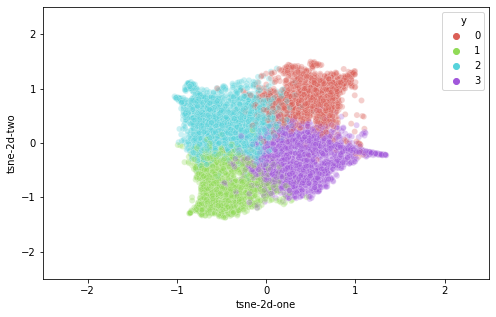

In [35]:
import seaborn as sns
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['y'] = np.hstack((y_preds_km))
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne-2d-one", 
    y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 4),
    data=df_subset,
    legend="full",
    alpha=0.3
)
plt.xlim([-2.5,2.5])
plt.ylim([-2.5,2.5])